[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/sachdevkartik/GSoC-2022/blob/main/test1.ipynb)


# __Classifying Dark Matter Substructure using Equivariant Neural Networks__

This approach adapts the existing [Equivariant Neural Networks](https://github.com/ML4SCI/DeepLense/tree/main/Equivariant_Neural_Networks_for_DeepLense_Apoorva_Singh) which is further inspired by Weiler et. al [General E(2)-Equivariant Steerable CNNs](https://github.com/QUVA-Lab/e2cnn) to the given [dataset](https://drive.google.com/file/d/1B_UZtU4W65ZViTJsLeFfvK-xXCYUhw2A/view).

The Dark Matter Substructure consists of larger groups of symmetries, including rotations which the convential Convolutional Neural Networks (CNNs) are not robust to. Vanilla Convolutional Neural Networks (CNNs) are majorly invariant to translation. 

Hence, to learn a good representation of Dark Matter Substructure, E2-CNNs architecture are used as they are equivariant under all isometries E(2) of the image plane i.e. under translations, rotations and reflections.

This resulted in a network with around *0.46M parameters* and a training time of approx. 6 hours on RTX 2070 8 GB (laptop version) with the given dataset.

## __Results__

| S.No | Metric | Value |
| --- | --- | --- |
| 1. | Best validation accuracy | 94.81% |
| 2. | AUC (without sub structure)  | 0.9936 |
| 3. | AUC (sphere)  | 0.9845 |
| 4. | AUC (Vortex)  | 0.9936 |






# __Google colab__
To run in Google colab, please execute the below cell for installing the requisite dependencies.

In [ ]:
# !pip install e2cnn
# !pip install gdown
# %sudo apt install unzip

# __Running Locally__
To run locally, please execute the below cell for installing CUDA, pytorch among other dependencies and set up the conda env. If some of the dependcies are already installed like pytorch or cuda, please cherrypick dependencis from the ```setup.bash``` file

In [ ]:
# %%bash
# bash setup.bash

# __Essential imports__

In [3]:
import sys
import os
import time
import logging
import argparse
import shutil
import torch
import copy
import torchvision
import numpy as np
import pandas as pd
from PIL import Image
from os import listdir
from os.path import join
import torch.optim as optim
from e2cnn import gspaces, nn
import matplotlib.pyplot as plt
from skimage import io, transform
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, utils
import torch.nn.functional as F
from torchvision.transforms import RandomRotation, Pad, Resize, ToTensor, Compose
import torchvision.transforms as transforms
from sklearn.metrics import roc_curve, auc, confusion_matrix
import warnings
from torchsummary import summary
warnings.filterwarnings('ignore')
import gdown
import splitfolders

## __Make required folders for data and models__

In [5]:
# check if the directory for data exists else make it
os.makedirs('data', exist_ok=True)
os.makedirs("model", exist_ok=True)

## __Download data__
The Dataset consists of three classes, strong lensing images with no substructure, subhalo substructure, and vortex substructure. The images have been normalized using min-max normalization.

| S.No | Classes | # Images |
| --- | --- | --- |
| 1. | With subhalo substructure | 12500 |
| 2. | Without substructure | 12500 |
| 3. | Vortex substructure | 12500 |


In [6]:
# check if the compressed data file from gdrive exist 
# else download in the directory
if not os.path.isfile('data/dataset.zip'):
    url = "https://drive.google.com/uc?id=1B_UZtU4W65ZViTJsLeFfvK-xXCYUhw2A"
    output = "data/dataset.zip"
    gdown.download(url, output, quiet=False)
else:
    print("File exists")

Downloading...
From: https://drive.google.com/uc?id=1B_UZtU4W65ZViTJsLeFfvK-xXCYUhw2A
To: /home/kartik/git/GSoc2022_test/data/dataset.zip
100%|██████████| 1.13G/1.13G [01:45<00:00, 10.7MB/s]


## __Extract data__
Check if the compressed data file is already extracted else extract data <br>

The data folder looks like: 

```bash
    dataset
    ├── train
    │   ├── no
    │   ├── sphere
    │   └── vort
    └── val
        ├── no
        ├── sphere
        └── vort

```

In [7]:
# initialize the data directory name  
data_dir = 'data/dataset'

if os.path.isdir(data_dir):
    print("Extracted folder exists")
else:
    print("Extracting folder")
    os.system('unzip data/dataset.zip -d data')

Extracting folder


In [ ]:
print(f"Torch: {torch.__version__}")

## __Set Config and Hyperparameters__

In [8]:
# Data setting
n_classes = 3               # number of classes to be classified
img_size = 129              # image size (129x129)
sym_group = 'Circular'      # Symmetry group to be used 'Circular'
N = 4                       # Order of the symmetry group


# Training parameters
batch_size = 64             # batch size
epochs = 40                 # number of epochs        
lr = 5e-5                   # learning rate

# optimizer parameters
weight_decay = 1e-7         # L2 penalty
gamma = 0.5                 # factor by which to decrease learning
step_size_opt = 5           # interval to apply optimizer scheduler
use_lr_schedule = False     # To apply LR scheduler or not

seed = 42                   # fixing seed for repeatability
use_cuda = True             # Using CUDA
cuda_idx = 0                # idx of CUDA device to be used


# Path settings
PY_PATH = os.path.abspath('')               # absolute path of jupyter file
data_dir = os.path.join(PY_PATH, data_dir)  # absolute path of dataset


## __Select CUDA device for training__

In [9]:
def get_device(use_cuda=True, cuda_idx=0):
    """Get the CUDA device

    Args:
        use_cuda (Bool): To used CUDA or not
        cuda_idx (int): index of CUDA device 
    
    Returns:
        device: CUDA device(s) being used 
    """
    
    if use_cuda:
        if torch.cuda.is_available():
            assert cuda_idx in range(0, torch.cuda.device_count()),\
                "GPU index out of range. index lies in [{}, {})".format(0, torch.cuda.device_count())
            device = torch.device("cuda:"+str(cuda_idx))
        else:
            print("cuda not found, will switch to cpu")
    else:
        device = torch.device("cpu")
    print(f'Using device = {str(device)}')
    return device

In [10]:
device = get_device(use_cuda, cuda_idx)

Using device = cuda:0


#### __Logger to save the results__

In [11]:
def init_logging_handler(log_dir, current_time, extra=''):
    """Initializes the handler for logger. Create the logger directory if it doest exists. 
        Define the format of logging
        DEBUG logging level being used

    Args:
        log_dir (str): Logger directory
        current_time (str): time from logging to begin  
        extra (str): Space for adding extra info in .txt file
    
    """

    if not os.path.exists(log_dir):
        os.makedirs(log_dir)

    if not os.path.exists(os.path.join(log_dir, current_time)):
        os.makedirs(os.path.join(log_dir, current_time))

    stderr_handler = logging.StreamHandler()
    file_handler = logging.FileHandler('{}/{}/log_{}.txt'.format(
        log_dir, current_time, current_time + extra))
    logging.basicConfig(handlers=[stderr_handler, file_handler])
    logger = logging.getLogger()
    logger.setLevel(logging.DEBUG)
    
logging.getLogger('matplotlib.font_manager').disabled = True

In [6]:
current_time = time.strftime("%Y-%m-%d-%H-%M-%S", time.localtime())
log_dir = 'logger'
init_logging_handler(log_dir, current_time)

## __Transformations__ 

Following transformations are performed on the dataset:

1. Randomly crop to $128 \times 128$ 
2. Padded to increase to $129 \times 129$
3. Resized to $387 \times 387$
4. Randomly rotate between 0 $^{\circ}$ -180 $^{\circ}$ 
7. Resized to $129 \times 129$.
8. Converting to grayscale
9. Converting PIL image to tensor

Transformation were refered from the existing implementation with equivariant networks mentioned above.

In [12]:
# images are padded to have shape 129x129.
# this allows to use odd-size filters with stride 2 when downsampling a feature map in the model
pad = Pad((0, 0, 1, 1), fill=0)
# to reduce interpolation artifacts (e.g. when testing the model on rotated images),
# we upsample an image by a factor of 3, rotate it and finally downsample it again
resize1 = Resize(387)
resize2 = Resize(129)
totensor = ToTensor()
togray = transforms.Grayscale(num_output_channels=1)

In [13]:
transform_train = transforms.Compose([
    transforms.RandomCrop(128),
    pad,
    resize1,
    RandomRotation(180, resample=Image.BILINEAR, expand=False),
    resize2,
    togray,
    totensor,
])
transform_test = transforms.Compose([
    transforms.RandomCrop(128),
    pad,
    togray,
    totensor,
])

## __Defining custom dataset for given data__

In [14]:
class CustomDataset(Dataset):
    def __init__(self, root_dir, mode, transform=None):
        assert mode in ['train', 'test']

        self.root_dir = root_dir

        if mode == "train":
            self.root_dir = self.root_dir+"/train"
        else:
            self.root_dir = self.root_dir+"/val"

        self.transform = transform
        classes = listdir(self.root_dir) # [join(self.root_dir, x).split('/')[3] for x in listdir(self.root_dir)]
        classes.sort()
        self.class_to_idx = {cls_name: i for i, cls_name in enumerate(classes)}
        self.imagefilename = []
        self.labels = []
        
        for i in classes:
            for x in listdir(join(self.root_dir, i)):
                self.imagefilename.append(join(self.root_dir, i,x))
                self.labels.append(self.class_to_idx[i])

    
    def __getitem__(self, index):
        image, label = self.imagefilename[index], self.labels[index]
        
        image = np.load(image, allow_pickle=True)[0]
        image = image / image.max() #normalizes data in range 0 - 255
        image = 255 * image
        image  = Image.fromarray(image.astype('uint8')).convert("RGB")
        if self.transform is not None:
            image = self.transform(image)
        return image, label
    
    def __len__(self):
        return len(self.labels)

In [15]:
trainset = CustomDataset(data_dir,'train',transform_train)
testset = CustomDataset(data_dir, 'test',transform=transform_test)

## __Dataloader__
Loading train and test data with shuffle and given batch size

In [16]:
train_loader = torch.utils.data.DataLoader(trainset, batch_size=batch_size,shuffle=True)
test_loader = torch.utils.data.DataLoader(testset, batch_size=batch_size,shuffle=True)

## __Visualize image samples__

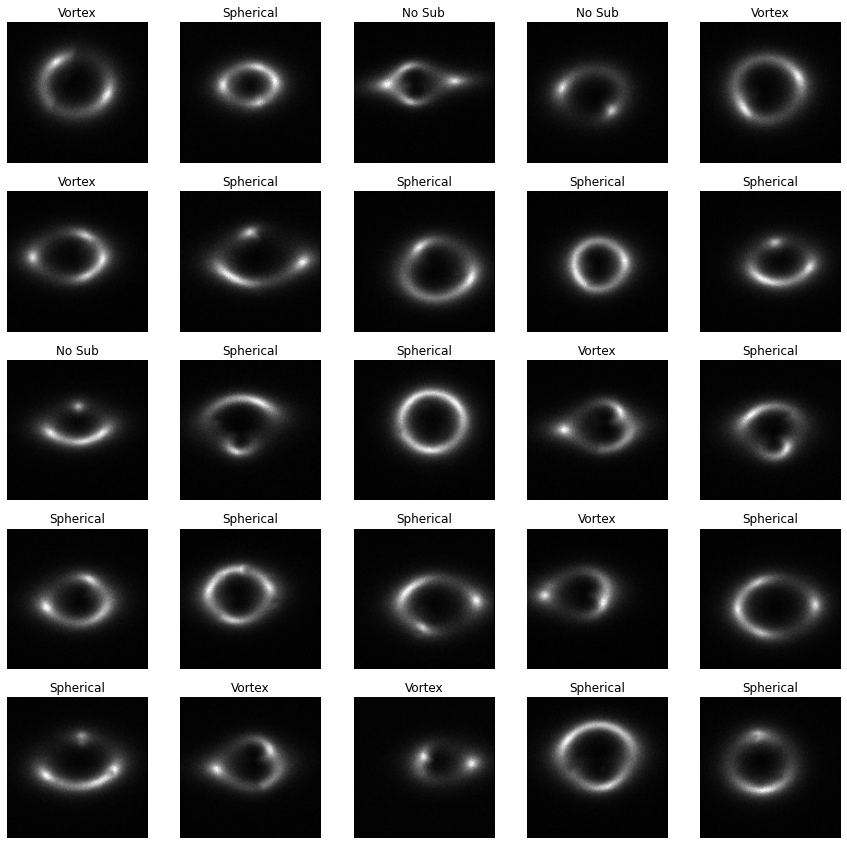

In [12]:
labels_map = {0: 'No Sub',1:'Spherical', 2:'Vortex'}
figure = plt.figure(figsize=(15, 15))
cols, rows = 5, 5
for i in range(1, cols * rows + 1):
    sample_idx = torch.randint(len(testset), size=(1,)).item()
    img, label = testset[sample_idx]
    figure.add_subplot(rows, cols, i)
    plt.title(labels_map[label])
    plt.axis("off")
    plt.imshow(img.squeeze(), cmap="gray")
plt.show()

### **Model Definition**
Since the input images are gray-scale, the input model type will be scalar field. Inside the network, we use regular fields. Finally, group pooling is used to build invariant features. Two fully connected layers perform the final classification.

In [17]:
class Equivariant_Network(torch.nn.Module):
    
    def __init__(self, n_classes=n_classes, sym_group = sym_group, N = N):
        
        super(Equivariant_Network, self).__init__()
        
        # Dihyderal Equivariance
        if sym_group == 'Dihyderal':
            self.r2_act = gspaces.FlipRot2dOnR2(N=N)

        # Circular Equivariance
        elif sym_group == 'Circular':
            self.r2_act = gspaces.Rot2dOnR2(N=N)

        
        # the input image is a scalar field, corresponding to the trivial representation
        in_type = nn.FieldType(self.r2_act, [self.r2_act.trivial_repr])
        
        # we store the input type for wrapping the images into a geometric tensor during the forward pass
        self.input_type = in_type
        print('##### in_type: #####', in_type)
        
        # convolution 1
        # first specify the output type of the convolutional layer
        # we choose 24 feature fields, each transforming under the regular representation of C8
        out_type = nn.FieldType(self.r2_act, 24*[self.r2_act.regular_repr])
        self.block1 = nn.SequentialModule(
            nn.MaskModule(in_type, 129, margin=1),
            nn.R2Conv(in_type, out_type, kernel_size=7, padding=1, bias=False),
            nn.InnerBatchNorm(out_type),
            nn.ReLU(out_type, inplace=True)
        )
        
        # convolution 2
        # the old output type is the input type to the next layer
        in_type = self.block1.out_type
        # the output type of the second convolution layer are 48 regular feature fields of C8
        out_type = nn.FieldType(self.r2_act, 48*[self.r2_act.regular_repr])
        self.block2 = nn.SequentialModule(
            nn.R2Conv(in_type, out_type, kernel_size=5, padding=2, bias=False),
            nn.InnerBatchNorm(out_type),
            nn.ReLU(out_type, inplace=True)
        )
        self.pool1 = nn.SequentialModule(
            nn.PointwiseAvgPoolAntialiased(out_type, sigma=0.66, stride=2)
        )
        
        # convolution 3
        # the old output type is the input type to the next layer
        in_type = self.block2.out_type
        # the output type of the third convolution layer are 48 regular feature fields of C8
        out_type = nn.FieldType(self.r2_act, 48*[self.r2_act.regular_repr])
        self.block3 = nn.SequentialModule(
            nn.R2Conv(in_type, out_type, kernel_size=5, padding=2, bias=False),
            nn.InnerBatchNorm(out_type),
            nn.ReLU(out_type, inplace=True)
        )
        
        # convolution 4
        # the old output type is the input type to the next layer
        in_type = self.block3.out_type
        # the output type of the fourth convolution layer are 96 regular feature fields of C8
        out_type = nn.FieldType(self.r2_act, 96*[self.r2_act.regular_repr])
        self.block4 = nn.SequentialModule(
            nn.R2Conv(in_type, out_type, kernel_size=5, padding=2, bias=False),
            nn.InnerBatchNorm(out_type),
            nn.ReLU(out_type, inplace=True)
        )
        self.pool2 = nn.SequentialModule(
            nn.PointwiseAvgPoolAntialiased(out_type, sigma=0.66, stride=2)
        )
        
        # convolution 5
        # the old output type is the input type to the next layer
        in_type = self.block4.out_type
        # the output type of the fifth convolution layer are 96 regular feature fields of C8
        out_type = nn.FieldType(self.r2_act, 96*[self.r2_act.regular_repr])
        self.block5 = nn.SequentialModule(
            nn.R2Conv(in_type, out_type, kernel_size=5, padding=2, bias=False),
            nn.InnerBatchNorm(out_type),
            nn.ReLU(out_type, inplace=True)
        )
        
        # convolution 6
        # the old output type is the input type to the next layer
        in_type = self.block5.out_type
        # the output type of the sixth convolution layer are 64 regular feature fields of C8
        out_type = nn.FieldType(self.r2_act, 64*[self.r2_act.regular_repr])
        self.block6 = nn.SequentialModule(
            nn.R2Conv(in_type, out_type, kernel_size=5, padding=1, bias=False),
            nn.InnerBatchNorm(out_type),
            nn.ReLU(out_type, inplace=True)
        )
        self.pool3 = nn.PointwiseAvgPoolAntialiased(out_type, sigma=0.66, stride=1, padding=0)
        
        self.gpool = nn.GroupPooling(out_type)
        
        # number of output channels
        c = self.gpool.out_type.size
        
        # Fully Connected
        self.fully_net = torch.nn.Sequential(
            torch.nn.Linear(43264, 64),
            torch.nn.BatchNorm1d(64),
            torch.nn.ELU(inplace=True),
            torch.nn.Linear(64, n_classes),
        )
    
    def forward(self, input: torch.Tensor):
        # wrap the input tensor in a GeometricTensor
        # (associate it with the input type)
        # print('input: ', input)
        # print('input: ', self.input_type)
        x = nn.GeometricTensor(input, self.input_type)
        
        # apply each equivariant block
        
        # Each layer has an input and an output type
        # A layer takes a GeometricTensor in input.
        # This tensor needs to be associated with the same representation of the layer's input type
        #
        # The Layer outputs a new GeometricTensor, associated with the layer's output type.
        # As a result, consecutive layers need to have matching input/output types
        x = self.block1(x)
        x = self.block2(x)
        x = self.pool1(x)
        
        x = self.block3(x)
        x = self.block4(x)
        x = self.pool2(x)
        
        x = self.block5(x)
        x = self.block6(x)
        
        # pool over the spatial dimensions
        x = self.pool3(x)
        
        # pool over the group
        x = self.gpool(x)

        # unwrap the output GeometricTensor
        # (take the Pytorch tensor and discard the associated representation)
        x = x.tensor
        
        # classify with the final fully connected layers)
        x = self.fully_net(x.reshape(x.shape[0], -1))
        
        return x
    

## __Model Initialization__

In [14]:
model = Equivariant_Network(n_classes=n_classes, sym_group = sym_group, N =N).to(device)

##### in_type: ##### [4-Rotations: {irrep_0}]


## __Defining optimizer__

In [15]:
loss_function = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=lr, weight_decay=1e-5)
total_epochs = epochs
log_interval = 100  #Intervals after which results are displayed

## __Training__

In [16]:
all_train_loss = []
all_test_loss = []
all_train_accuracy = []
all_test_accuracy = []

best_accuracy = 0

for epoch in range(total_epochs):
    model.train()
    tr_loss_epoch = []
    test_loss_epoch = []
    total = 0
    correct = 0
    for i, (x, t) in enumerate(train_loader):        
        optimizer.zero_grad()

        x = x.to(device)
        t = t.to(device)

        y = model(x)
        y_pred = y.flatten().to(torch.float64)
        
        _, prediction = torch.max(y.data, 1)
        total += t.shape[0]
        correct += (prediction == t).sum().item()
        loss = loss_function(y, t)
        tr_loss_epoch.append(loss.item())
        if i % log_interval == 0:
            print('Loss: ',loss.item())
        loss.backward()

        optimizer.step()
      
    all_train_loss.append(np.asarray(tr_loss_epoch))
    all_train_accuracy.append(correct/total*100)
    
    
    if epoch % 1 == 0:
        total = 0
        correct = 0
        with torch.no_grad():
            model.eval()
            for i, (x, t) in enumerate(test_loader):
                x = x.to(device)
                t = t.to(device)
                y = model(x)
                
                loss = loss_function(y, t)
                test_loss_epoch.append(loss.item())

                _, prediction = torch.max(y.data, 1)
                total += t.shape[0]
                correct += (prediction == t).sum().item()
                
        all_test_loss.append(np.asarray(test_loss_epoch))
        all_test_accuracy.append(correct/total*100)
        logging.debug("epoch {} | test accuracy: {}".format(epoch,correct/total*100))
        
        test_accuracy = correct/total*100
        
        if test_accuracy > best_accuracy:
            best_accuracy = test_accuracy
            best_model = copy.deepcopy(model)    

all_epochs = [i for i in range (total_epochs)]

all_train_loss_mean = [j.mean() for j in all_train_loss]
all_test_loss_mean = [j.mean() for j in all_test_loss]

Loss:  1.0975779294967651
Loss:  1.1324087381362915
Loss:  1.096057415008545
Loss:  1.0916314125061035
Loss:  1.1510201692581177


DEBUG:root:epoch 0 | test accuracy: 34.28


Loss:  1.0977997779846191
Loss:  1.0990346670150757
Loss:  1.0723415613174438
Loss:  1.0467277765274048
Loss:  0.9664154052734375


DEBUG:root:epoch 1 | test accuracy: 49.68


Loss:  0.90601646900177
Loss:  0.8628373742103577
Loss:  0.9053385257720947
Loss:  0.7669607400894165
Loss:  0.789669930934906


DEBUG:root:epoch 2 | test accuracy: 40.69333333333333


Loss:  0.7122402787208557
Loss:  0.749890148639679
Loss:  0.5417349338531494
Loss:  0.43363747000694275
Loss:  0.4399668574333191


DEBUG:root:epoch 3 | test accuracy: 83.16


Loss:  0.4099697768688202
Loss:  0.4195922017097473
Loss:  0.3702259659767151
Loss:  0.46034833788871765
Loss:  0.3018529415130615


DEBUG:root:epoch 4 | test accuracy: 71.56


Loss:  0.21648597717285156
Loss:  0.4271918535232544
Loss:  0.41455650329589844
Loss:  0.24736326932907104
Loss:  0.3138616681098938


DEBUG:root:epoch 5 | test accuracy: 83.49333333333333


Loss:  0.2438136488199234
Loss:  0.19304312765598297
Loss:  0.31774458289146423
Loss:  0.2596754729747772
Loss:  0.3776642382144928


DEBUG:root:epoch 6 | test accuracy: 89.46666666666667


Loss:  0.3470025360584259
Loss:  0.2244076430797577
Loss:  0.2483520209789276
Loss:  0.27963903546333313
Loss:  0.1851661205291748


DEBUG:root:epoch 7 | test accuracy: 83.10666666666665


Loss:  0.28514963388442993
Loss:  0.1565634161233902
Loss:  0.45835667848587036
Loss:  0.28254836797714233
Loss:  0.43999388813972473


DEBUG:root:epoch 8 | test accuracy: 85.94666666666667


Loss:  0.2618005573749542
Loss:  0.21675138175487518
Loss:  0.3289259970188141
Loss:  0.35868802666664124
Loss:  0.22283831238746643


DEBUG:root:epoch 9 | test accuracy: 87.58666666666667


Loss:  0.22404126822948456
Loss:  0.2437770515680313
Loss:  0.2384437918663025
Loss:  0.24954204261302948
Loss:  0.22496198117733002


DEBUG:root:epoch 10 | test accuracy: 91.2


Loss:  0.39751556515693665
Loss:  0.22240684926509857
Loss:  0.23541958630084991
Loss:  0.2371644675731659
Loss:  0.31650450825691223


DEBUG:root:epoch 11 | test accuracy: 92.38666666666666


Loss:  0.25859835743904114
Loss:  0.24574320018291473
Loss:  0.16627059876918793
Loss:  0.2913077771663666
Loss:  0.10681947320699692


DEBUG:root:epoch 12 | test accuracy: 80.97333333333333


Loss:  0.16212962567806244
Loss:  0.18647204339504242
Loss:  0.1973697543144226
Loss:  0.3123931884765625
Loss:  0.22344128787517548


DEBUG:root:epoch 13 | test accuracy: 88.66666666666667


Loss:  0.16559305787086487
Loss:  0.17730405926704407
Loss:  0.1317458152770996
Loss:  0.23878073692321777
Loss:  0.17777211964130402


DEBUG:root:epoch 14 | test accuracy: 90.09333333333333


Loss:  0.11125616729259491
Loss:  0.12816037237644196
Loss:  0.3182661533355713
Loss:  0.24966377019882202
Loss:  0.22901932895183563


DEBUG:root:epoch 15 | test accuracy: 82.18666666666667


Loss:  0.18813227117061615
Loss:  0.16193829476833344
Loss:  0.09796027094125748
Loss:  0.22519467771053314
Loss:  0.21186532080173492


DEBUG:root:epoch 16 | test accuracy: 90.57333333333332


Loss:  0.2701510787010193
Loss:  0.12093976140022278
Loss:  0.24237892031669617
Loss:  0.2048192173242569
Loss:  0.08074712008237839


DEBUG:root:epoch 17 | test accuracy: 92.88


Loss:  0.263813853263855
Loss:  0.24986599385738373
Loss:  0.32820814847946167
Loss:  0.21912626922130585
Loss:  0.09401994943618774


DEBUG:root:epoch 18 | test accuracy: 81.38666666666666


Loss:  0.18946397304534912
Loss:  0.18362492322921753
Loss:  0.24941183626651764
Loss:  0.1964491754770279
Loss:  0.15093235671520233


DEBUG:root:epoch 19 | test accuracy: 88.97333333333334


Loss:  0.1523110419511795
Loss:  0.1457115113735199
Loss:  0.17659686505794525
Loss:  0.3097490966320038
Loss:  0.21171577274799347


DEBUG:root:epoch 20 | test accuracy: 91.88


Loss:  0.13834801316261292
Loss:  0.20280231535434723
Loss:  0.14415176212787628
Loss:  0.2576337456703186
Loss:  0.08984658867120743


DEBUG:root:epoch 21 | test accuracy: 90.14666666666666


Loss:  0.15912692248821259
Loss:  0.1349024921655655
Loss:  0.08031757920980453
Loss:  0.09862440079450607
Loss:  0.16520234942436218


DEBUG:root:epoch 22 | test accuracy: 91.08000000000001


Loss:  0.10325922816991806
Loss:  0.16799655556678772
Loss:  0.20817571878433228
Loss:  0.0649929940700531
Loss:  0.22048765420913696


DEBUG:root:epoch 23 | test accuracy: 92.21333333333334


Loss:  0.048989247530698776
Loss:  0.15662726759910583
Loss:  0.1411145180463791
Loss:  0.18812426924705505
Loss:  0.09507999569177628


DEBUG:root:epoch 24 | test accuracy: 93.53333333333333


Loss:  0.16306474804878235
Loss:  0.09611766785383224
Loss:  0.3646138608455658
Loss:  0.13177387416362762
Loss:  0.0753670334815979


DEBUG:root:epoch 25 | test accuracy: 93.26666666666667


Loss:  0.20395135879516602
Loss:  0.08465203642845154
Loss:  0.17526394128799438
Loss:  0.07356838136911392
Loss:  0.09912458062171936


DEBUG:root:epoch 26 | test accuracy: 93.66666666666667


Loss:  0.06935639679431915
Loss:  0.1902816891670227
Loss:  0.10673942416906357
Loss:  0.12995603680610657
Loss:  0.17048397660255432


DEBUG:root:epoch 27 | test accuracy: 94.13333333333334


Loss:  0.1438862532377243
Loss:  0.0507703460752964
Loss:  0.1725640445947647
Loss:  0.08965694159269333
Loss:  0.1274179220199585


DEBUG:root:epoch 28 | test accuracy: 89.93333333333334


Loss:  0.13583756983280182
Loss:  0.06592173874378204
Loss:  0.07403423637151718
Loss:  0.10116160660982132
Loss:  0.22596466541290283


DEBUG:root:epoch 29 | test accuracy: 92.88


Loss:  0.08947866410017014
Loss:  0.14404630661010742
Loss:  0.2866123616695404
Loss:  0.0997786894440651
Loss:  0.14424914121627808


DEBUG:root:epoch 30 | test accuracy: 90.30666666666667


Loss:  0.07827723771333694
Loss:  0.06822627037763596
Loss:  0.18522551655769348
Loss:  0.1063716933131218
Loss:  0.11595140397548676


DEBUG:root:epoch 31 | test accuracy: 89.66666666666666


Loss:  0.1391083002090454
Loss:  0.14848357439041138
Loss:  0.13950090110301971
Loss:  0.11217991262674332
Loss:  0.0803777277469635


DEBUG:root:epoch 32 | test accuracy: 94.81333333333333


Loss:  0.026842504739761353
Loss:  0.08788321167230606
Loss:  0.026223378255963326
Loss:  0.12029626965522766
Loss:  0.08352406322956085


DEBUG:root:epoch 33 | test accuracy: 94.14666666666666


Loss:  0.30843424797058105
Loss:  0.12846948206424713
Loss:  0.12682421505451202
Loss:  0.17960873246192932
Loss:  0.10314412415027618


DEBUG:root:epoch 34 | test accuracy: 94.67999999999999


Loss:  0.03349073603749275
Loss:  0.057605911046266556
Loss:  0.04894525185227394
Loss:  0.07626146078109741
Loss:  0.09894408285617828


DEBUG:root:epoch 35 | test accuracy: 94.13333333333334


Loss:  0.11568250507116318
Loss:  0.06483649462461472
Loss:  0.2700241804122925
Loss:  0.050827961415052414
Loss:  0.10006546974182129


DEBUG:root:epoch 36 | test accuracy: 94.77333333333333


Loss:  0.04533912241458893
Loss:  0.11163386702537537
Loss:  0.0599546916782856
Loss:  0.14353889226913452
Loss:  0.072599396109581


DEBUG:root:epoch 37 | test accuracy: 93.77333333333333


Loss:  0.11330202221870422
Loss:  0.06580237299203873
Loss:  0.2569134533405304
Loss:  0.0775701180100441
Loss:  0.04135411977767944


DEBUG:root:epoch 38 | test accuracy: 91.4


Loss:  0.11725694686174393
Loss:  0.0810142382979393
Loss:  0.15411445498466492
Loss:  0.04870305210351944
Loss:  0.13244493305683136


DEBUG:root:epoch 39 | test accuracy: 93.8


In [28]:
# saving best trained model
PATH_MODEL = os.path.join(PY_PATH, "model")
os.makedirs(PATH_MODEL, exist_ok=True)
PATH = os.path.join(PATH_MODEL, "cnn_state_dict_model.pt")
torch.save(best_model.state_dict(), PATH)

## __Evaluation__

##### in_type: ##### [4-Rotations: {irrep_0}]


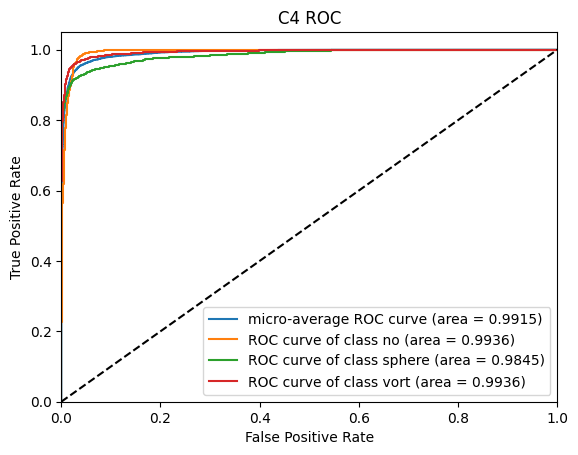

In [20]:
def to_one_hot_vector(num_class, label):
    b = np.zeros((label.shape[0], num_class))
    b[np.arange(label.shape[0]), label] = 1

    return b.astype(int)

plt.rcParams.update(plt.rcParamsDefault)

total = 0
all_test_loss = []
all_test_accuracy = []
label_true_arr = []
label_true_arr_onehot = []
label_pred_arr = []
pred_arr = []

PATH_MODEL = os.path.join(PY_PATH, "model")
# os.makedirs(PATH_MODEL, exist_ok=True)
PATH = os.path.join(PATH_MODEL, "cnn_state_dict_model.pt")
best_model = Equivariant_Network(n_classes=n_classes, sym_group = sym_group, N =N).to(device)
best_model.load_state_dict(torch.load(PATH))

correct = 0
with torch.no_grad():
    best_model.eval()
    for i, (x, t) in enumerate(test_loader):
        x = x.to(device)
        t = t.to(device)
        y = best_model(x)

        pred_arr.append(y.cpu().numpy())


        _, prediction = torch.max(y.data, 1)
        label_pred_arr.append(prediction.cpu().numpy())
        total += t.shape[0]
        correct += (prediction == t).sum().item()
        label_true_arr.append(t.cpu().numpy())

        one_hot_t = to_one_hot_vector(3,t.cpu().numpy())
        label_true_arr_onehot.append(one_hot_t)

y_pred = []
for i in label_pred_arr:
    for j in i:
        y_pred.append(j)
y_pred = np.array(y_pred)        
        
y_true_onehot = []
for i in label_true_arr_onehot:
    for j in i:
        y_true_onehot.append(list(j))
y_true_onehot = np.array(y_true_onehot)

y_score = []
for i in pred_arr:
    for j in i:
        y_score.append(list(j))
y_score = np.array(y_score)

y_true = []
for i in label_true_arr:
    for j in i:
        y_true.append(j)
y_true = np.array(y_true)

fpr = dict()
tpr = dict()
roc_auc = dict()


for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_true_onehot[:, i], y_score[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])


inv_map = {v: k for k, v in testset.class_to_idx.items()}



# Compute micro-average ROC curve and ROC area
fpr["micro"], tpr["micro"], _ = roc_curve(y_true_onehot.ravel(), y_score.ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

plt.figure()
plt.plot(fpr["micro"], tpr["micro"],
         label='micro-average ROC curve (area = {0:0.4f})'
               ''.format(roc_auc["micro"]))
for i in range(n_classes):
    plt.plot(fpr[i], tpr[i], label='ROC curve of class '+ inv_map[i]+ ' (area = {0:0.4f})'
                                   ''.format(roc_auc[i]))

plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title(sym_group[0]+str(N)+' ROC')
plt.legend(loc="lower right")
plt.show()

In [21]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    import itertools
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')


    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()
    plt.show()

Confusion matrix, without normalization


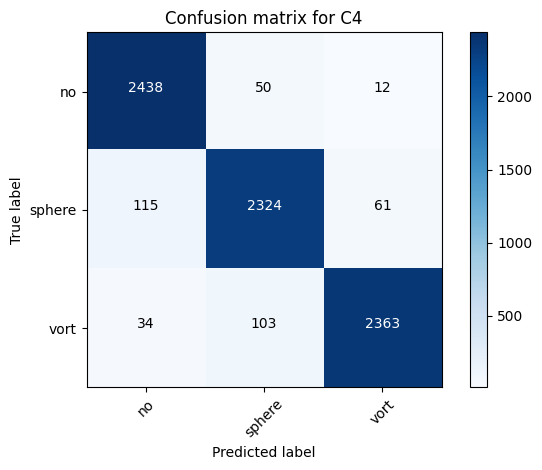

In [22]:
cnf_matrix = confusion_matrix(y_true, y_pred, labels=[0, 1, 2])

np.set_printoptions(precision=2)

# Plot non-normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=[inv_map[0], inv_map[1], inv_map[2]],title='Confusion matrix for '+sym_group[0]+str(N))

## Cite

Inspired from [General E(2)-Equivariant Steerable CNNs](https://arxiv.org/abs/1911.08251).
 
```
@inproceedings{e2cnn,
    title={{General E(2)-Equivariant Steerable CNNs}},
    author={Weiler, Maurice and Cesa, Gabriele},
    booktitle={Conference on Neural Information Processing Systems (NeurIPS)},
    year={2019},
}
```

Apoorva Singh, Yurii Halychanskyi, Marcos Tidball, DeepLense, (2021), GitHub repository, https://github.com/ML4SCI/DeepLense